In [1]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec


warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [33]:
#########################
############ Hyperparamter
#########################

st_dev = 0.1
learning_rate = 0.04
training_iters = 8000000
batch_size = 128
display_step = 100

n_input = 41 # Number of features
n_steps = 1 # timesteps
n_hidden = 128 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [3]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [22]:
tf.reset_default_graph()

tf.set_random_seed(0.5)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])
#keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Define weights
W = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_classes], stddev=st_dev, seed=0.5))
}

b = {
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [23]:
def RNN(x, W, b):

    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, state_is_tuple = True)
        
    # Get lstm cell output
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']

In [24]:

pred = RNN(x, W, b)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [30]:
# Launch the graph
with tf.Session() as sess:

    sess.run(init)
    step = 1
    losses = {'train':[], 'validation':[]}
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        offset_test = (step * batch_size) % (y_test.shape[0] - batch_size)
        
        # Generate minibatches for training and validating.
        batch_x = x_train[offset:(offset + batch_size), :]
        batch_y = y_train[offset:(offset + batch_size), :]
        batch_test_x = x_test[offset_test:(offset_test + batch_size), :]
        batch_test_y = y_test[offset_test:(offset_test + batch_size), :]
        
        # Reshape data to feed into RNN
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        batch_test_x = batch_test_x.reshape((batch_size, n_steps, n_input))
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        loss_test = sess.run(cost, feed_dict={x: batch_test_x, y: batch_test_y})

        if step % display_step == 0:

            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Accuracy= " + \
                  "{:.6f}".format(loss)
                        
        losses['train'].append(loss)
        losses['validation'].append(loss_test)
        step += 1
            
    print("Optimization Finished!")

    # Generate confusion matrix for metrics computation
    y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input))})
    y_true = np.argmax(y_test,1)
    conf_matrix = met.confusion_matrix(y_true, y_pred)
    
    

Iter 12800, Minibatch Loss= 0.919305, Minibatch Val Accuracy= 0.919305
Iter 25600, Minibatch Loss= 0.004287, Minibatch Val Accuracy= 0.004287
Iter 38400, Minibatch Loss= 0.000049, Minibatch Val Accuracy= 0.000049
Iter 51200, Minibatch Loss= 0.333830, Minibatch Val Accuracy= 0.333830
Iter 64000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 76800, Minibatch Loss= 0.039556, Minibatch Val Accuracy= 0.039556
Iter 89600, Minibatch Loss= 0.002514, Minibatch Val Accuracy= 0.002514
Iter 102400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 115200, Minibatch Loss= 0.000004, Minibatch Val Accuracy= 0.000004
Iter 128000, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 140800, Minibatch Loss= 0.006680, Minibatch Val Accuracy= 0.006680
Iter 153600, Minibatch Loss= 0.000021, Minibatch Val Accuracy= 0.000021
Iter 166400, Minibatch Loss= 0.000010, Minibatch Val Accuracy= 0.000010
Iter 179200, Minibatch Loss= 0.000009, Minibatch Val Accuracy= 0.000009

Iter 1472000, Minibatch Loss= 0.000015, Minibatch Val Accuracy= 0.000015
Iter 1484800, Minibatch Loss= 0.000015, Minibatch Val Accuracy= 0.000015
Iter 1497600, Minibatch Loss= 0.000065, Minibatch Val Accuracy= 0.000065
Iter 1510400, Minibatch Loss= 0.000001, Minibatch Val Accuracy= 0.000001
Iter 1523200, Minibatch Loss= 1.485922, Minibatch Val Accuracy= 1.485922
Iter 1536000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 1548800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 1561600, Minibatch Loss= 0.001407, Minibatch Val Accuracy= 0.001407
Iter 1574400, Minibatch Loss= 0.541542, Minibatch Val Accuracy= 0.541542
Iter 1587200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 1600000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 1612800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 1625600, Minibatch Loss= 0.055479, Minibatch Val Accuracy= 0.055479
Iter 1638400, Minibatch Loss= 0.000000, Minibatch V

Iter 2918400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 2931200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 2944000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 2956800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 2969600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 2982400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 2995200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3008000, Minibatch Loss= 0.000358, Minibatch Val Accuracy= 0.000358
Iter 3020800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3033600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3046400, Minibatch Loss= 0.000050, Minibatch Val Accuracy= 0.000050
Iter 3059200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3072000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 3084800, Minibatch Loss= 0.000000, Minibatch V

Iter 4364800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4377600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4390400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4403200, Minibatch Loss= 0.004361, Minibatch Val Accuracy= 0.004361
Iter 4416000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4428800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4441600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4454400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4467200, Minibatch Loss= 0.000001, Minibatch Val Accuracy= 0.000001
Iter 4480000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4492800, Minibatch Loss= 0.000020, Minibatch Val Accuracy= 0.000020
Iter 4505600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4518400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 4531200, Minibatch Loss= 0.039436, Minibatch V

Iter 5811200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5824000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5836800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5849600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5862400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5875200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5888000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5900800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5913600, Minibatch Loss= 0.000001, Minibatch Val Accuracy= 0.000001
Iter 5926400, Minibatch Loss= 0.000002, Minibatch Val Accuracy= 0.000002
Iter 5939200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5952000, Minibatch Loss= 0.000296, Minibatch Val Accuracy= 0.000296
Iter 5964800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 5977600, Minibatch Loss= 6.797385, Minibatch V

Iter 7257600, Minibatch Loss= 0.000830, Minibatch Val Accuracy= 0.000830
Iter 7270400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7283200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7296000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7308800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7321600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7334400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7347200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7360000, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7372800, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7385600, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7398400, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7411200, Minibatch Loss= 0.000000, Minibatch Val Accuracy= 0.000000
Iter 7424000, Minibatch Loss= 0.000573, Minibatch V

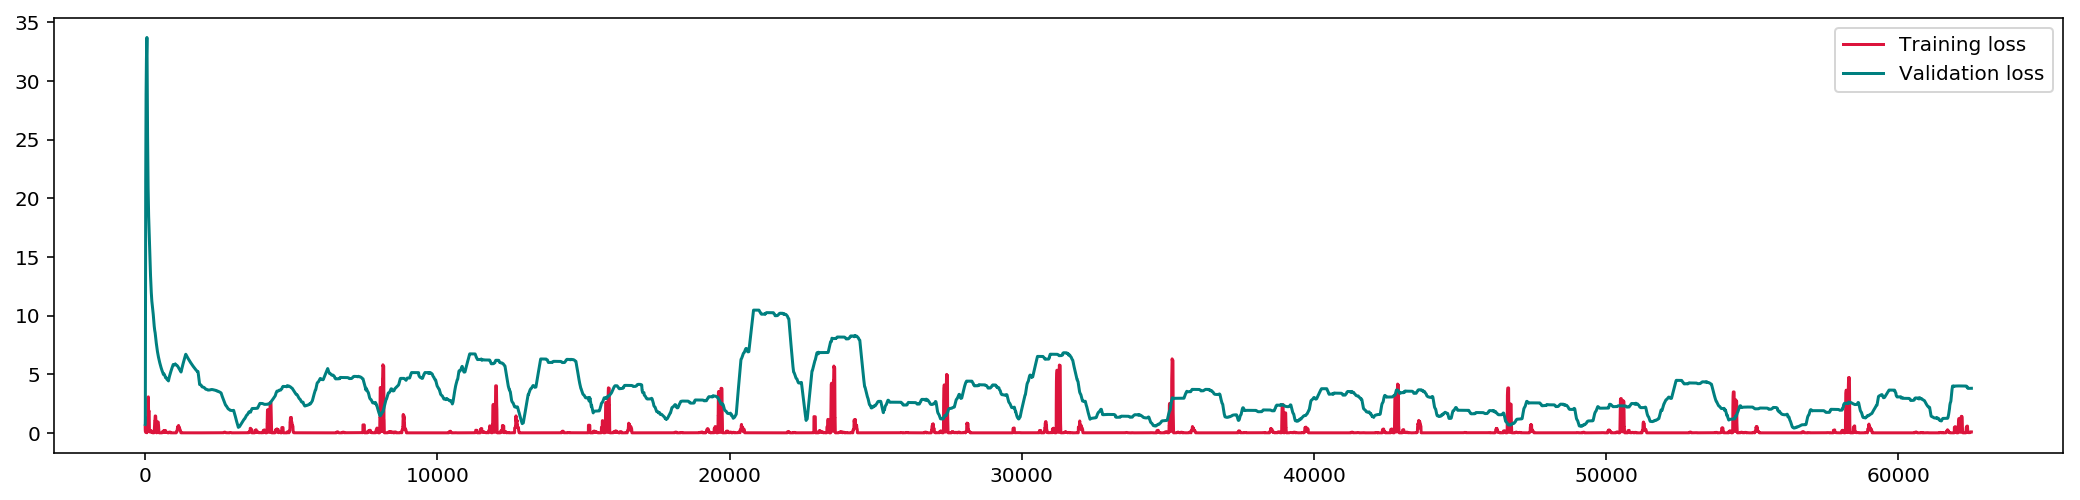

In [35]:

smoothed_loss = hm.running_mean(losses['train'], 50)
smoothed_loss_train = hm.running_mean(losses['validation'], 1800)

fig = plt.figure(figsize=(18,4))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax1.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
#plt.ylim([-0.2,3.5])
plt.show()

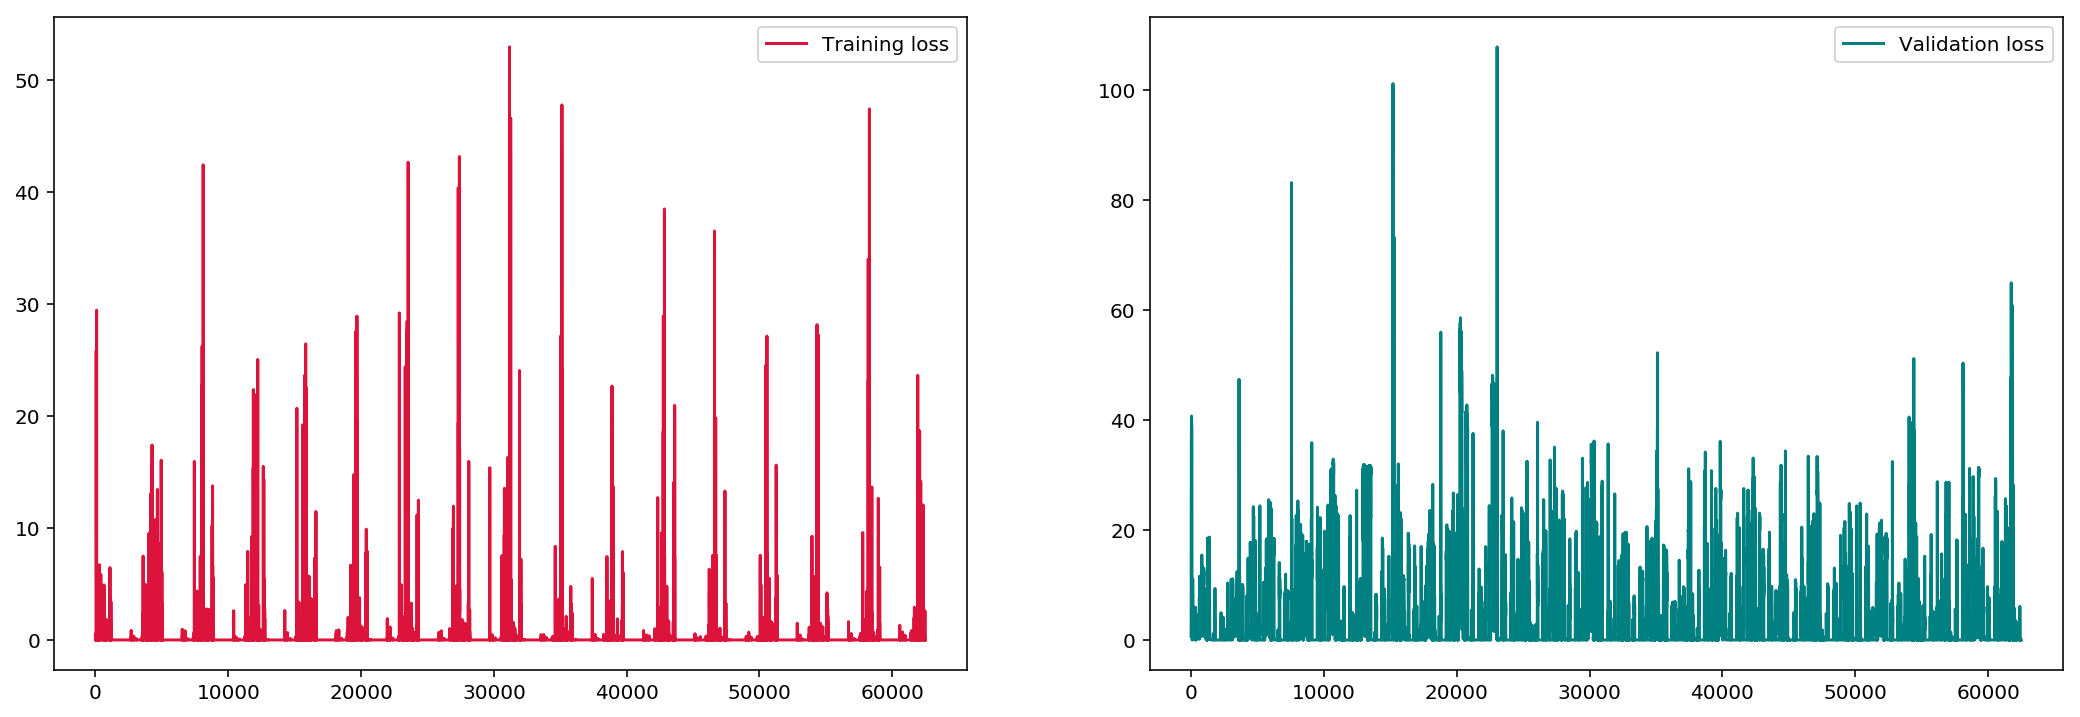

In [36]:
fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:])

ax1.plot(losses['train'], label='Training loss', color='crimson')
ax2.plot(losses['validation'], label='Validation loss', color='teal')
ax1.legend()
ax2.legend()

plt.show()

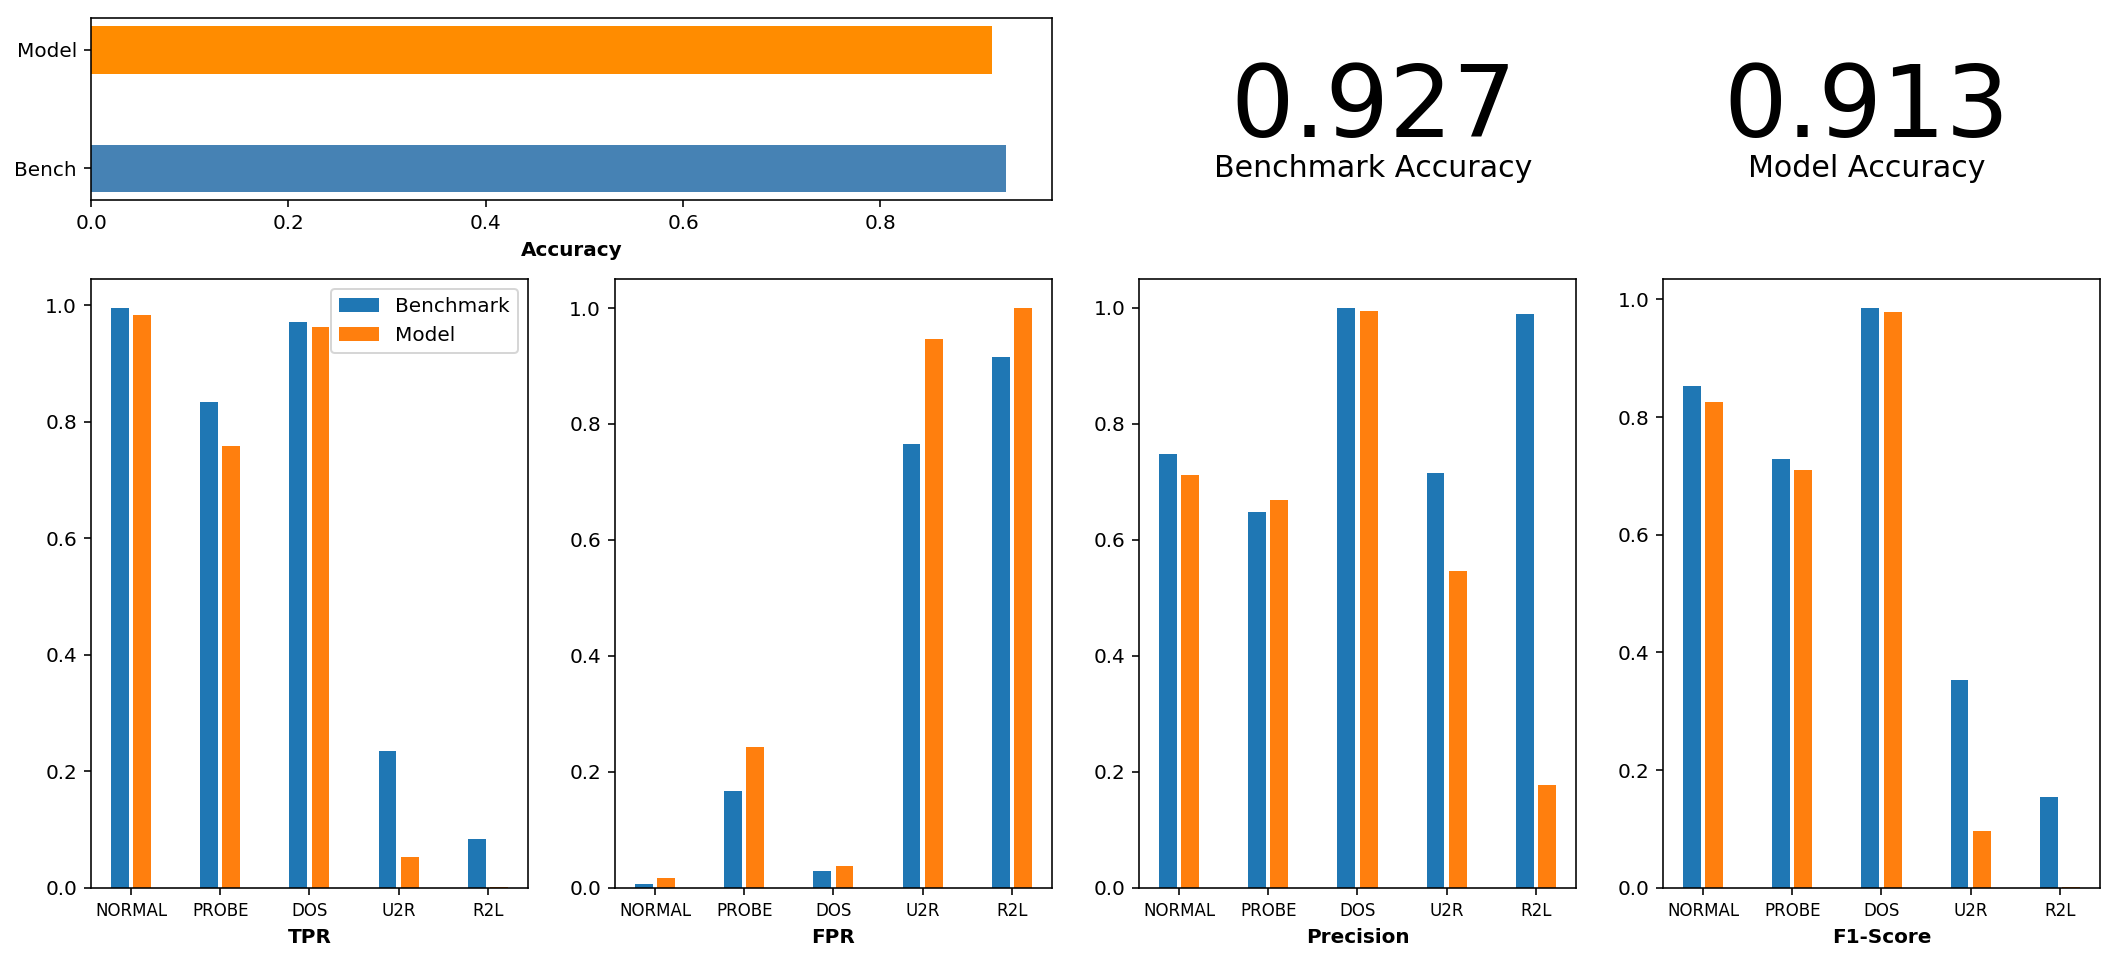

In [37]:
conf_bench = hm.getBenchmarkResults()
metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
hm.plotMetrics(metrics)